In [1]:
!pip install emoji
!pip install pyspellchecker
!pip install bert-tensorflow
!pip install transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234911 sha256=aad344cc9addfb01c1bfa1209aafea57c9c6ab9f0a284613ecc7bc1da5854fb3
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 39.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

import re

import emoji

from spellchecker import SpellChecker
spell = SpellChecker()

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

import random
from sklearn import metrics, model_selection, preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from transformers import BertTokenizerFast, TFBertModel, BertForSequenceClassification, TrainingArguments, Trainer
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [3]:
nltk.download("punkt")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**DATA EXPLORATION**

In [4]:
df = pd.read_csv("bonus_cov19_sa.csv")
df.head()

,Unnamed: 0,ID,Tweet,Labels
0,0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10
1,1,2,BanMediaHouse whose is responsible for spreadi...,6
2,2,3,Im waiting for someone to say to me that all t...,3 4
3,3,4,He is a liar. Proven day night. Time again. Li...,6
4,4,5,"NEW: U.S. CoronaVirus death toll reaches 4,000...",8


In [5]:
df = df.drop(["ID", "Unnamed: 0"], axis = 1)

In [6]:
df.head()

,Tweet,Labels
0,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10
1,BanMediaHouse whose is responsible for spreadi...,6
2,Im waiting for someone to say to me that all t...,3 4
3,He is a liar. Proven day night. Time again. Li...,6
4,"NEW: U.S. CoronaVirus death toll reaches 4,000...",8


**DATA PRE-PROCESSING**

In [7]:
# Define a function to correct spelling mistakes in a string
def correct_spelling(text):
    words = text.split()
    corrected_words = []
    for word in words:
        corrected_word = spell.correction(word)
        if corrected_word != None:
          corrected_words.append(corrected_word)
        # print(corrected_word)
    corrected_text = ' '.join(corrected_words)
    return corrected_text

In [8]:
abbreviations = {
    "w/": "with",
    "w/o": "without",
    "msg": "message",
    "u": "you",
    "r": "are",
    "lol": "laughing out loud",
    "np": "no problem",
    "LOL": "laughing out loud",
    "XD" : "laugh",
    "xd" : "laugh"
}

# Define a function to correct abbreviations in a string
def correct_abbreviations(text, abbreviations):
    words = text.split()
    corrected_words = []
    for word in words:
        if word in abbreviations:
            corrected_word = abbreviations[word]
            corrected_words.append(corrected_word)
        else:
            corrected_words.append(word)
    corrected_text = ' '.join(corrected_words)
    return corrected_text

In [9]:
def preprocess_tweets(tweet):
  # Convert all words to lower case
  tweet = tweet.lower()

  # Remove all punctuations
  tweet = tweet.translate(str.maketrans('', '', string.punctuation))

  # Remove all stop words
  # Tokenize the sentence
  tokens = nltk.word_tokenize(tweet)
  # Remove stop words
  clean_tokens = [token for token in tokens if not token.lower() in stop_words]
  # Join the tokens back into a sentence
  tweet = ' '.join(clean_tokens)

  # Removing HTML Tags, URLs and Website Links
  # Removing Website Links
  temp_text = tweet.split()

  for i in temp_text:
    if i[-4:] == ".com" or i[:4] == "www.":
      temp_text.remove(i)

  tweet = ' '.join(temp_text)

  # Remove HTML tags
  clean_text = re.sub('<[^<]+?>', '', tweet)

  # Remove URLs
  clean_text = re.sub(r'http\S+', '', clean_text)

  tweet = clean_text

  # Remove numbers
  tweet = re.sub(r'\d+', '', tweet)

  # Deemojize Emojis
  tweet = emoji.demojize(tweet)

  # Correct Abbreviations
  tweet = correct_abbreviations(tweet, abbreviations)

  # Remove mentions
  tweet = re.sub(r'@\w+', '', tweet)

  # Stemming
  # Tokenize the sentence
  tokens = nltk.word_tokenize(tweet)

  # Stem the tokens
  stemmed_tokens = [stemmer.stem(token) for token in tokens]

  # Join the stemmed tokens back into a sentence
  tweet = ' '.join(stemmed_tokens)

    # Spellcheck
  try:
    tweet = correct_spelling(tweet)
  except Exception as e:
    print(e)

  return tweet  

In [10]:
df["Tweet"] = df["Tweet"].map(preprocess_tweets)

In [11]:
df.head()

,Tweet,Labels
0,joke hop plane in well couid laugh out loud,0 10
1,whose response spread fake common story tandem...,6
2,im wait someone say corona thing april fool joke,3 4
3,liar proven day night time lie truth couid,6
4,new us death toll reach nearly new death repor...,8


In [12]:
# Convert strings of numbers to lists of integers
# If you have a space-separated string of numbers
df['Labels'] = df['Labels'].apply(lambda x: [int(i) for i in x.split()])
df['Labels'] = df['Labels'].apply(lambda x: [int(i) for i in x])

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the labels
binary_labels = mlb.fit_transform(df['Labels'])

# Convert binary labels to DataFrame
binary_labels_df = pd.DataFrame(binary_labels, columns=mlb.classes_)

# Concatenate original DataFrame with binary labels DataFrame
df = pd.concat([df, binary_labels_df], axis=1)

In [13]:
df.head()

,Tweet,Labels,0,1,2,3,4,5,6,7,8,9,10
0,joke hop plane in well couid laugh out loud,"[0, 10]",1,0,0,0,0,0,0,0,0,0,1
1,whose response spread fake common story tandem...,[6],0,0,0,0,0,0,1,0,0,0,0
2,im wait someone say corona thing april fool joke,"[3, 4]",0,0,0,1,1,0,0,0,0,0,0
3,liar proven day night time lie truth couid,[6],0,0,0,0,0,0,1,0,0,0,0
4,new us death toll reach nearly new death repor...,[8],0,0,0,0,0,0,0,0,1,0,0


In [14]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Downloading the .csv of the preprocessed Dataframe

df.to_csv("bonus_cov19_sa_preprocessed.csv",index = False)

In [16]:
# Initialize the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [17]:
class TweetDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets.iloc[idx]
        label = self.labels.iloc[idx].values
        label = torch.tensor(label).unsqueeze(0).to(device)

        inputs = tokenizer(tweet, truncation=True, padding='max_length', max_length=64)
        input_ids = torch.tensor(inputs['input_ids']).to(device)
        attention_mask = torch.tensor(inputs['attention_mask']).to(device)
        label = torch.tensor(label).to(device)

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}

In [18]:
# Split the data into train and validation sets

train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [19]:
train.head()

,Tweet,Labels,0,1,2,3,4,5,6,7,8,9,10
2579,govern accordingly keep tail indoor unless abs...,"[0, 4]",1,0,0,0,1,0,0,0,0,0,0
7128,do hikari alcohol drink help prevent corona ea...,"[3, 10]",0,0,0,1,0,0,0,0,0,0,1
4082,stage corona jihad tri spread infect get stray...,"[6, 7, 9]",0,0,0,0,0,0,1,1,0,1,0
2550,tik tok need get corona holy understand peopl ...,"[5, 6, 10]",0,0,0,0,0,1,1,0,0,0,1
4926,around time yearly vacay well cancel,"[5, 6]",0,0,0,0,0,1,1,0,0,0,0


In [20]:
X_train = train["Tweet"]
y_train = train.drop(columns=['Tweet', "Labels"])

X_test = test["Tweet"]
y_test = test.drop(columns=['Tweet', "Labels"])

X_val = val["Tweet"]
y_val = val.drop(columns=['Tweet', "Labels"])

In [21]:
# Create instances of the TweetDataset for training and validation data
train_data = TweetDataset(X_train, y_train)
val_data = TweetDataset(X_val, y_val)
test_data = TweetDataset(X_test, y_test)

# Create DataLoaders for training and validation data
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [22]:
# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=y_train.shape[1])
model.classifier = torch.nn.Linear(model.config.hidden_size, y_train.shape[1])
model.loss_fct = BCEWithLogitsLoss()
model = model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
# Training loop
for epoch in range(20):
    # Training
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device) 
        attention_mask = batch['attention_mask'].to(device) 
        labels = batch['labels'].float().to(device) 

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = model.loss_fct(logits.view(-1, y_train.shape[1]), labels.view(-1, y_train.shape[1]))
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")

    # Evaluation
    model.eval()
    total_val_loss = 0
    for batch in val_dataloader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device) 
            attention_mask = batch['attention_mask'].to(device) 
            labels = batch['labels'].float().to(device) 
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = model.loss_fct(logits.view(-1, y_train.shape[1]), labels.view(-1, y_train.shape[1]))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"Validation loss: {avg_val_loss}")

<ipython-input-17-8264a4a32b56>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Average training loss: 0.4736193133890629
Validation loss: 0.4070106792449951
Average training loss: 0.40334702089428903
Validation loss: 0.37866782903671264
Average training loss: 0.373557533621788
Validation loss: 0.3518491053581238
Average training loss: 0.33896020486950873
Validation loss: 0.3309845435619354
Average training loss: 0.3069499462842941
Validation loss: 0.3117297041416168
Average training loss: 0.2763964131474495
Validation loss: 0.3020669555664062
Average training loss: 0.2506731081753969
Validation loss: 0.28591012477874755
Average training loss: 0.22674077011644841
Validation loss: 0.2712191170454025
Average training loss: 0.20468391895294188
Validation loss: 0.2643250250816345
Average training loss: 0.18499426558613777
Validation loss: 0.2566517984867096
Average training loss: 0.16710895746946336
Validation loss: 0.24755310595035554
Average training loss: 0.15175610415637494
Validation loss: 0.24847892105579375
Average training loss: 0.1362012393772602
Validation l

In [24]:
model.eval()
total_test_loss = 0
for batch in test_dataloader:
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device) 
        attention_mask = batch['attention_mask'].to(device) 
        labels = batch['labels'].float().to(device) 

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = model.loss_fct(logits.view(-1, y_train.shape[1]), labels.view(-1, y_train.shape[1]))
        total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(test_dataloader)
print(f"Test loss: {avg_test_loss}")

<ipython-input-17-8264a4a32b56>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Test loss: 0.23495659371837974


In [25]:
from sklearn.metrics import f1_score

# Testing
model.eval()
total_test_loss = 0
all_predictions = []
all_true_labels = []
for batch in test_dataloader:
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device) 
        attention_mask = batch['attention_mask'].to(device) 
        labels = batch['labels'].float().to(device) 

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = model.loss_fct(logits.view(-1, y_train.shape[1]), labels.view(-1, y_train.shape[1]))
        total_test_loss += loss.item()

        # Apply sigmoid function for multi-label classification
        sigmoid_logits = torch.sigmoid(logits)
        # Convert to 0/1 labels based on a threshold of 0.5
        pred_labels = (sigmoid_logits > 0.5).int()

        all_predictions.append(pred_labels.detach().cpu().numpy())
        all_true_labels.append(labels.detach().cpu().numpy())

avg_test_loss = total_test_loss / len(test_dataloader)
print(f"Test loss: {avg_test_loss}")

<ipython-input-17-8264a4a32b56>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Test loss: 0.23495659371837974


In [27]:
# Flatten lists of predictions and true labels
all_predictions = np.vstack(all_predictions)
all_true_labels = np.vstack(all_true_labels)
all_true_labels = all_true_labels.astype(int)

# Calculate F1 score
f1_micro = f1_score(all_true_labels, all_predictions, average='micro')
print(f"Test F1 micro Score: {f1_micro}")

f1_macro = f1_score(all_true_labels, all_predictions, average='macro')
print(f"Test F1 macro Score: {f1_macro}")

Test F1 micro Score: 0.8055983564458141
Test F1 macro Score: 0.7757994164866114


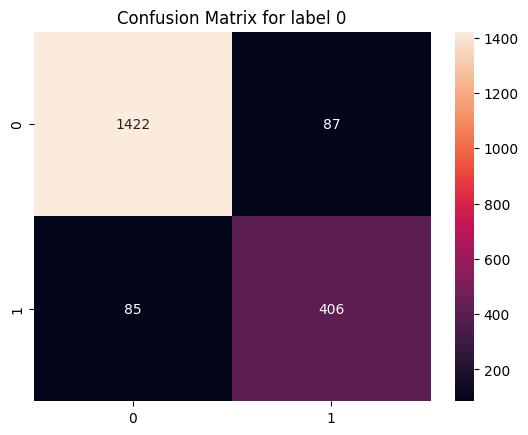

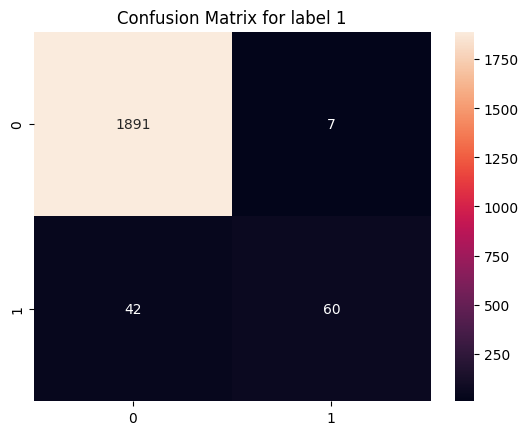

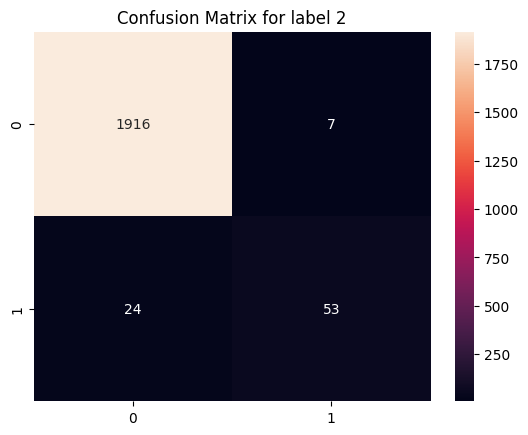

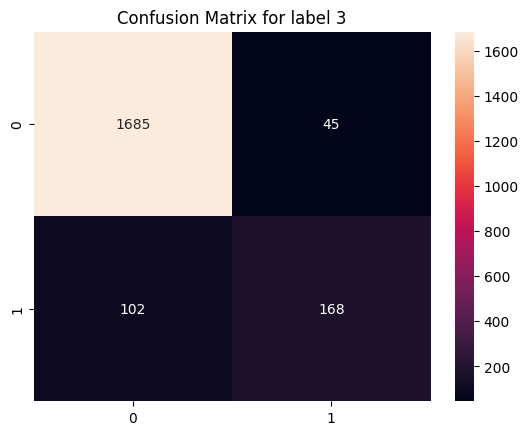

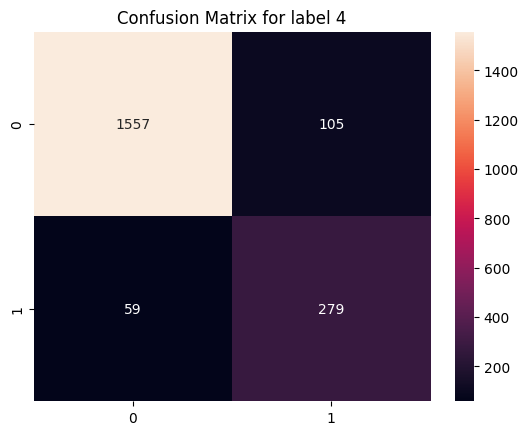

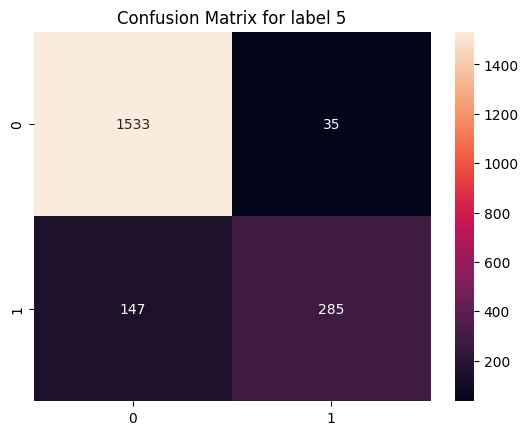

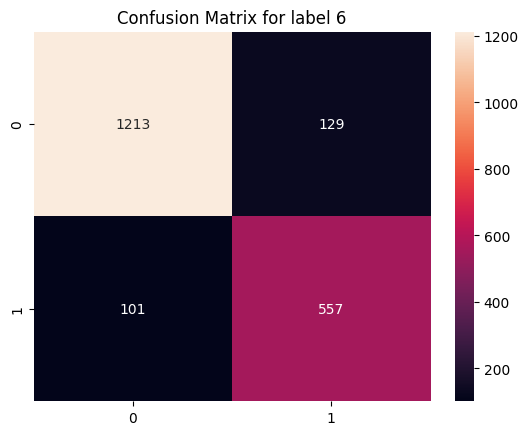

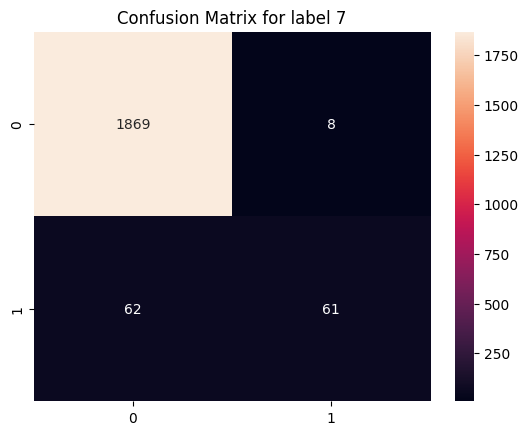

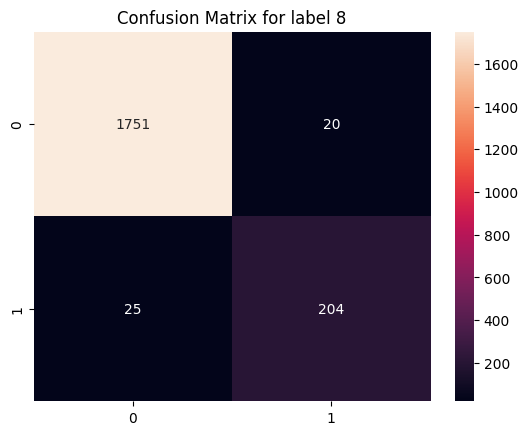

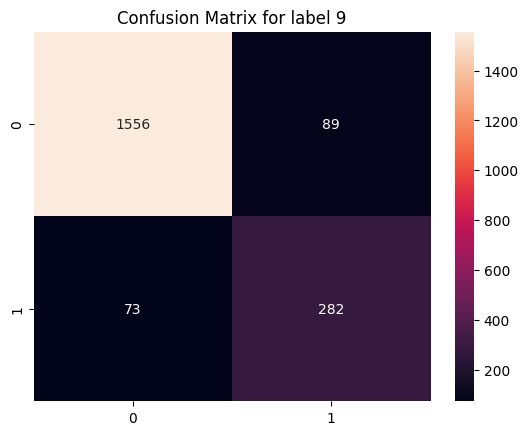

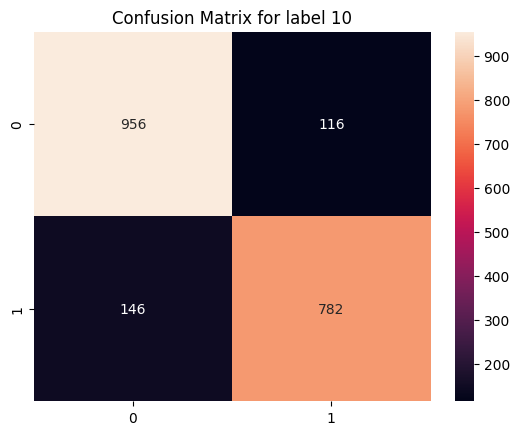

In [28]:
# Calculate confusion matrices for each label
confusion_matrices = multilabel_confusion_matrix(all_true_labels, all_predictions)

# Plot confusion matrix for each label
for i, matrix in enumerate(confusion_matrices):
    plt.figure()
    sns.heatmap(matrix, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for label {i}')
    plt.show()

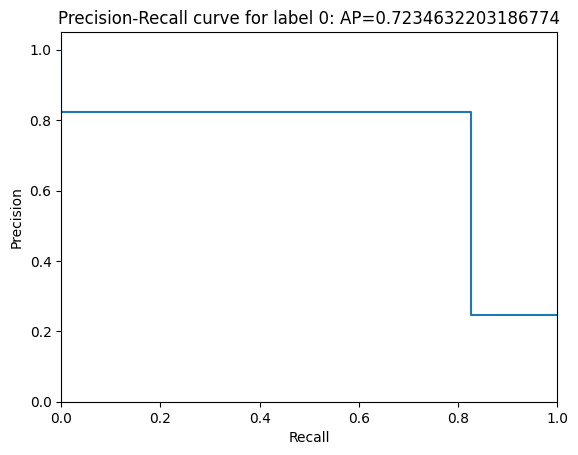

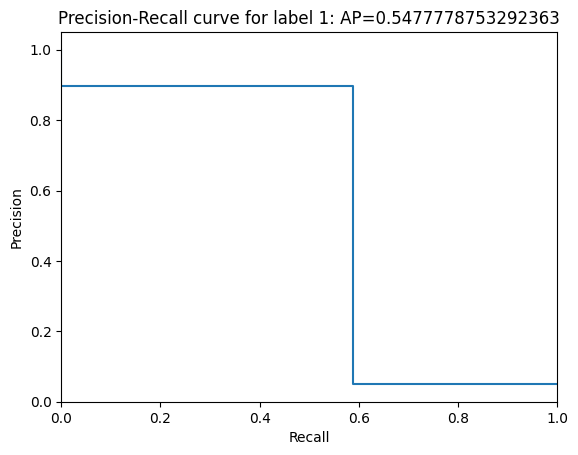

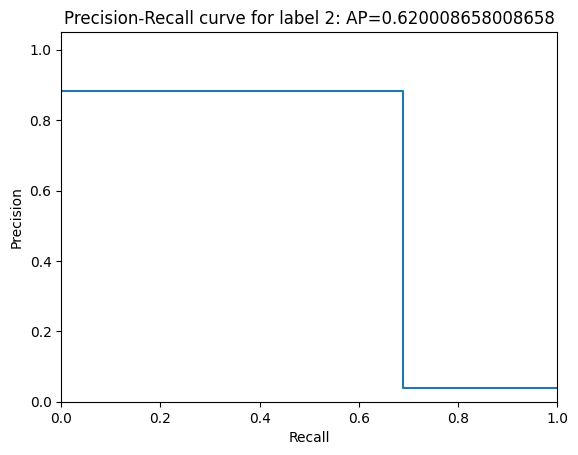

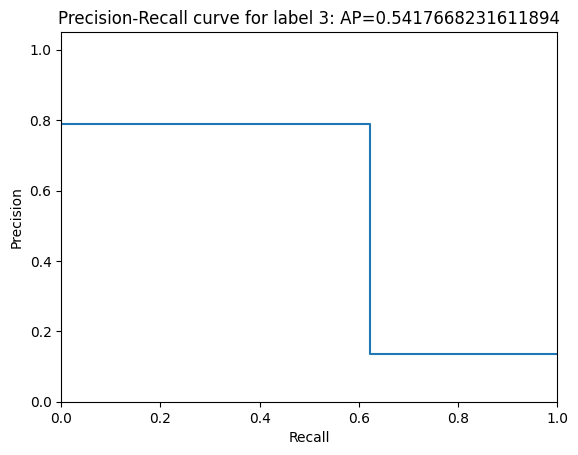

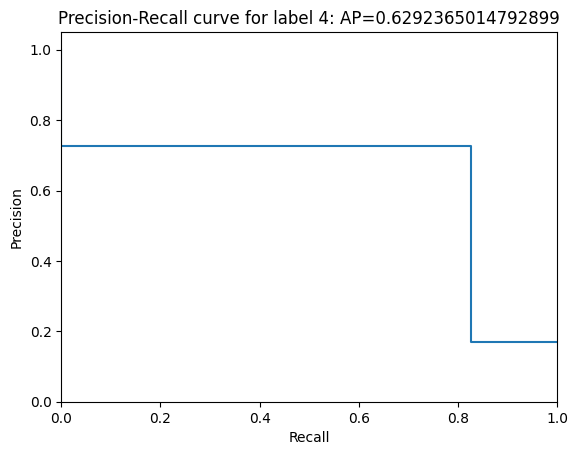

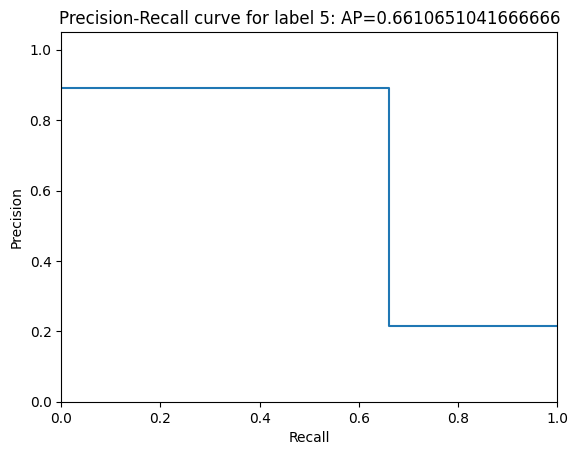

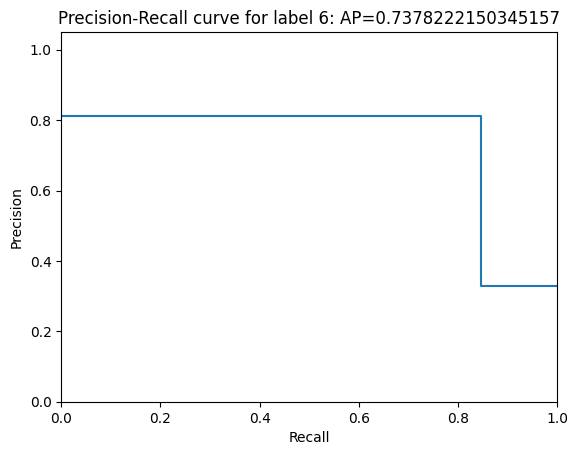

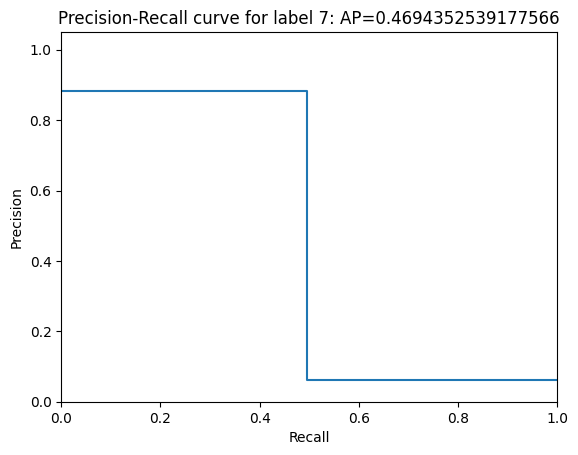

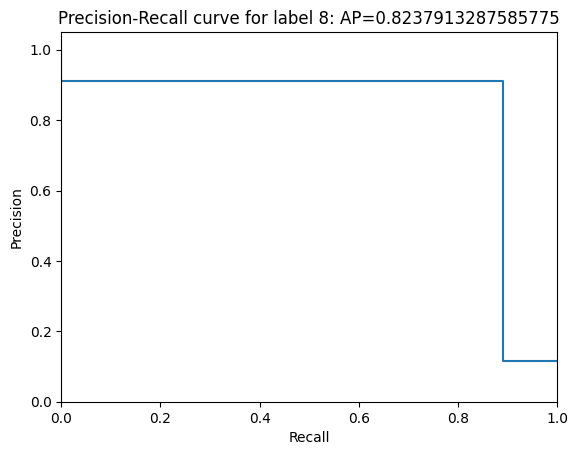

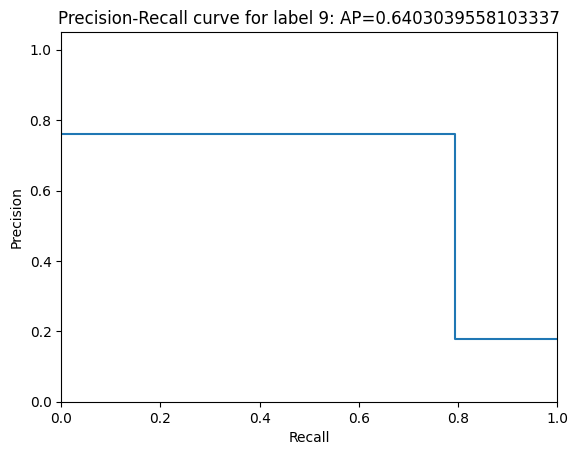

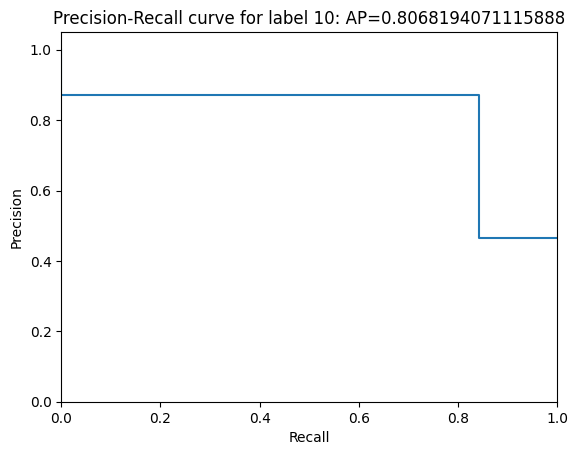

In [29]:
# Calculate precision-recall curve for each label
for i in range(all_true_labels.shape[1]):
    precision, recall, _ = precision_recall_curve(all_true_labels[:, i], all_predictions[:, i])
    average_precision = average_precision_score(all_true_labels[:, i], all_predictions[:, i])
    
    plt.figure()
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve for label {i}: AP={average_precision}')
    plt.show()

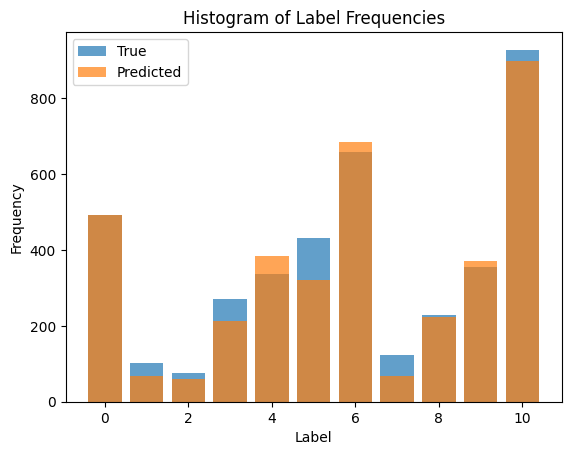

In [30]:
# Calculate frequencies of each label in the true labels and predictions
true_label_frequencies = np.sum(all_true_labels, axis=0)
predicted_label_frequencies = np.sum(all_predictions, axis=0)

# Plot histogram of label frequencies
plt.figure()
plt.bar(range(len(true_label_frequencies)), true_label_frequencies, alpha=0.7, label='True')
plt.bar(range(len(predicted_label_frequencies)), predicted_label_frequencies, alpha=0.7, label='Predicted')
plt.title('Histogram of Label Frequencies')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.legend()
plt.show()